# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

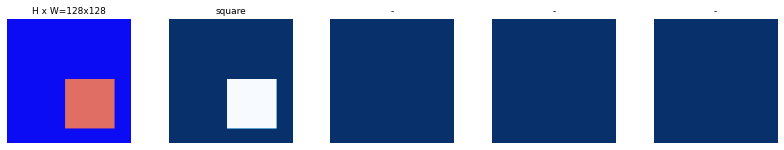

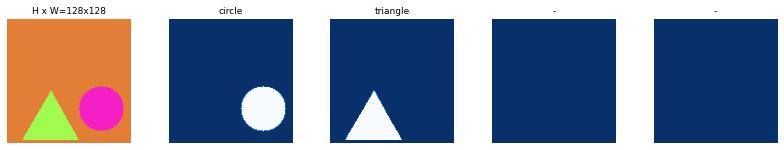

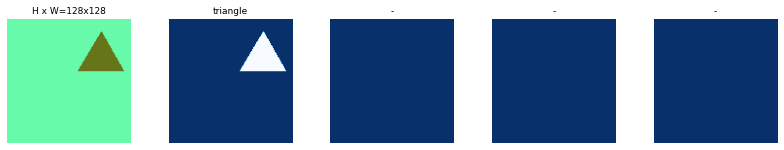

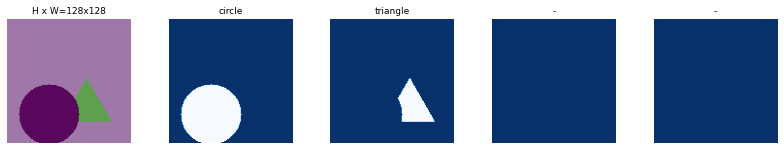

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Mask_RCNN\logs\shapes20200820T0511\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDi

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 8.0000 - loss: 7.6634 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 2.3037 - mrcnn_class_loss: 2.4058 - mrcnn_bbox_loss: 1.1124 - mrcnn_mask_loss: 1.7768

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  2/100 [..............................] - ETA: 20:07 - batch: 0.5000 - size: 8.0000 - loss: 7.4212 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 2.6383 - mrcnn_class_loss: 1.8566 - mrcnn_bbox_loss: 1.0313 - mrcnn_mask_loss: 1.8362 

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  3/100 [..............................] - ETA: 25:35 - batch: 1.0000 - size: 8.0000 - loss: 6.4656 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 2.2755 - mrcnn_class_loss: 1.5137 - mrcnn_bbox_loss: 1.0176 - mrcnn_mask_loss: 1.5973

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  4/100 [>.............................] - ETA: 28:07 - batch: 1.5000 - size: 8.0000 - loss: 5.9294 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 2.1112 - mrcnn_class_loss: 1.4023 - mrcnn_bbox_loss: 0.9803 - mrcnn_mask_loss: 1.3720

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  5/100 [>.............................] - ETA: 29:38 - batch: 2.0000 - size: 8.0000 - loss: 5.4892 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.8795 - mrcnn_class_loss: 1.3456 - mrcnn_bbox_loss: 0.9606 - mrcnn_mask_loss: 1.2364

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  6/100 [>.............................] - ETA: 30:16 - batch: 2.5000 - size: 8.0000 - loss: 5.0233 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.6922 - mrcnn_class_loss: 1.2082 - mrcnn_bbox_loss: 0.9289 - mrcnn_mask_loss: 1.1314

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  7/100 [=>............................] - ETA: 30:33 - batch: 3.0000 - size: 8.0000 - loss: 4.6635 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.5495 - mrcnn_class_loss: 1.1013 - mrcnn_bbox_loss: 0.9009 - mrcnn_mask_loss: 1.0526

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  8/100 [=>............................] - ETA: 30:40 - batch: 3.5000 - size: 8.0000 - loss: 4.4520 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.4928 - mrcnn_class_loss: 1.0221 - mrcnn_bbox_loss: 0.8881 - mrcnn_mask_loss: 0.9896

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  9/100 [=>............................] - ETA: 30:41 - batch: 4.0000 - size: 8.0000 - loss: 4.2505 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.4101 - mrcnn_class_loss: 0.9766 - mrcnn_bbox_loss: 0.8722 - mrcnn_mask_loss: 0.9335

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 10/100 [==>...........................] - ETA: 30:53 - batch: 4.5000 - size: 8.0000 - loss: 4.0636 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.3449 - mrcnn_class_loss: 0.9195 - mrcnn_bbox_loss: 0.8517 - mrcnn_mask_loss: 0.8901

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 11/100 [==>...........................] - ETA: 31:26 - batch: 5.0000 - size: 8.0000 - loss: 3.9281 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.3135 - mrcnn_class_loss: 0.8630 - mrcnn_bbox_loss: 0.8370 - mrcnn_mask_loss: 0.8586

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 12/100 [==>...........................] - ETA: 31:29 - batch: 5.5000 - size: 8.0000 - loss: 3.7629 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.2394 - mrcnn_class_loss: 0.8299 - mrcnn_bbox_loss: 0.8119 - mrcnn_mask_loss: 0.8274

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 13/100 [==>...........................] - ETA: 31:10 - batch: 6.0000 - size: 8.0000 - loss: 3.6100 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.1797 - mrcnn_class_loss: 0.7951 - mrcnn_bbox_loss: 0.7835 - mrcnn_mask_loss: 0.7992

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 14/100 [===>..........................] - ETA: 30:53 - batch: 6.5000 - size: 8.0000 - loss: 3.4674 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.1275 - mrcnn_class_loss: 0.7610 - mrcnn_bbox_loss: 0.7544 - mrcnn_mask_loss: 0.7733

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 15/100 [===>..........................] - ETA: 30:30 - batch: 7.0000 - size: 8.0000 - loss: 3.3508 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.0817 - mrcnn_class_loss: 0.7313 - mrcnn_bbox_loss: 0.7324 - mrcnn_mask_loss: 0.7559

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 16/100 [===>..........................] - ETA: 30:09 - batch: 7.5000 - size: 8.0000 - loss: 3.2518 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.0536 - mrcnn_class_loss: 0.7028 - mrcnn_bbox_loss: 0.7128 - mrcnn_mask_loss: 0.7344

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 17/100 [====>.........................] - ETA: 29:49 - batch: 8.0000 - size: 8.0000 - loss: 3.1761 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.0280 - mrcnn_class_loss: 0.6843 - mrcnn_bbox_loss: 0.6962 - mrcnn_mask_loss: 0.7205

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 18/100 [====>.........................] - ETA: 29:26 - batch: 8.5000 - size: 8.0000 - loss: 3.0913 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.9987 - mrcnn_class_loss: 0.6619 - mrcnn_bbox_loss: 0.6799 - mrcnn_mask_loss: 0.7046

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 19/100 [====>.........................] - ETA: 29:09 - batch: 9.0000 - size: 8.0000 - loss: 3.0133 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.9682 - mrcnn_class_loss: 0.6432 - mrcnn_bbox_loss: 0.6655 - mrcnn_mask_loss: 0.6912

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 20/100 [=====>........................] - ETA: 28:55 - batch: 9.5000 - size: 8.0000 - loss: 2.9615 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.9536 - mrcnn_class_loss: 0.6317 - mrcnn_bbox_loss: 0.6544 - mrcnn_mask_loss: 0.6775

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 21/100 [=====>........................] - ETA: 28:39 - batch: 10.0000 - size: 8.0000 - loss: 2.9011 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.9376 - mrcnn_class_loss: 0.6146 - mrcnn_bbox_loss: 0.6417 - mrcnn_mask_loss: 0.6638

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 22/100 [=====>........................] - ETA: 28:18 - batch: 10.5000 - size: 8.0000 - loss: 2.8384 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.9155 - mrcnn_class_loss: 0.5988 - mrcnn_bbox_loss: 0.6282 - mrcnn_mask_loss: 0.6536

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 23/100 [=====>........................] - ETA: 27:59 - batch: 11.0000 - size: 8.0000 - loss: 2.7806 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.8944 - mrcnn_class_loss: 0.5838 - mrcnn_bbox_loss: 0.6183 - mrcnn_mask_loss: 0.6424

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 24/100 [======>.......................] - ETA: 27:51 - batch: 11.5000 - size: 8.0000 - loss: 2.7296 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.8745 - mrcnn_class_loss: 0.5729 - mrcnn_bbox_loss: 0.6107 - mrcnn_mask_loss: 0.6304

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 25/100 [======>.......................] - ETA: 27:32 - batch: 12.0000 - size: 8.0000 - loss: 2.6721 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.8590 - mrcnn_class_loss: 0.5579 - mrcnn_bbox_loss: 0.5986 - mrcnn_mask_loss: 0.6162

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 26/100 [======>.......................] - ETA: 27:13 - batch: 12.5000 - size: 8.0000 - loss: 2.6287 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.8472 - mrcnn_class_loss: 0.5467 - mrcnn_bbox_loss: 0.5882 - mrcnn_mask_loss: 0.6062

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 27/100 [=======>......................] - ETA: 27:01 - batch: 13.0000 - size: 8.0000 - loss: 2.5727 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.8339 - mrcnn_class_loss: 0.5328 - mrcnn_bbox_loss: 0.5745 - mrcnn_mask_loss: 0.5918

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 28/100 [=======>......................] - ETA: 26:45 - batch: 13.5000 - size: 8.0000 - loss: 2.5252 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.8181 - mrcnn_class_loss: 0.5217 - mrcnn_bbox_loss: 0.5629 - mrcnn_mask_loss: 0.5833

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 29/100 [=======>......................] - ETA: 26:55 - batch: 14.0000 - size: 8.0000 - loss: 2.4923 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.8113 - mrcnn_class_loss: 0.5127 - mrcnn_bbox_loss: 0.5551 - mrcnn_mask_loss: 0.5744

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 30/100 [========>.....................] - ETA: 26:39 - batch: 14.5000 - size: 8.0000 - loss: 2.4497 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.7980 - mrcnn_class_loss: 0.5035 - mrcnn_bbox_loss: 0.5459 - mrcnn_mask_loss: 0.5637

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 31/100 [========>.....................] - ETA: 26:22 - batch: 15.0000 - size: 8.0000 - loss: 2.4119 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.7877 - mrcnn_class_loss: 0.4960 - mrcnn_bbox_loss: 0.5362 - mrcnn_mask_loss: 0.5535

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 32/100 [========>.....................] - ETA: 26:02 - batch: 15.5000 - size: 8.0000 - loss: 2.3711 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.7780 - mrcnn_class_loss: 0.4870 - mrcnn_bbox_loss: 0.5252 - mrcnn_mask_loss: 0.5426

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 33/100 [========>.....................] - ETA: 25:39 - batch: 16.0000 - size: 8.0000 - loss: 2.3353 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.7680 - mrcnn_class_loss: 0.4815 - mrcnn_bbox_loss: 0.5153 - mrcnn_mask_loss: 0.5325

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 34/100 [=========>....................] - ETA: 25:14 - batch: 16.5000 - size: 8.0000 - loss: 2.2997 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.7606 - mrcnn_class_loss: 0.4736 - mrcnn_bbox_loss: 0.5062 - mrcnn_mask_loss: 0.5217

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 35/100 [=========>....................] - ETA: 24:52 - batch: 17.0000 - size: 8.0000 - loss: 2.2648 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.7544 - mrcnn_class_loss: 0.4650 - mrcnn_bbox_loss: 0.4970 - mrcnn_mask_loss: 0.5110

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 36/100 [=========>....................] - ETA: 24:28 - batch: 17.5000 - size: 8.0000 - loss: 2.2380 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.7464 - mrcnn_class_loss: 0.4610 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.5034

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 37/100 [==========>...................] - ETA: 24:09 - batch: 18.0000 - size: 8.0000 - loss: 2.2070 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.7400 - mrcnn_class_loss: 0.4546 - mrcnn_bbox_loss: 0.4817 - mrcnn_mask_loss: 0.4936

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 38/100 [==========>...................] - ETA: 23:48 - batch: 18.5000 - size: 8.0000 - loss: 2.1742 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.7313 - mrcnn_class_loss: 0.4468 - mrcnn_bbox_loss: 0.4741 - mrcnn_mask_loss: 0.4849

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 39/100 [==========>...................] - ETA: 23:24 - batch: 19.0000 - size: 8.0000 - loss: 2.1460 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.7232 - mrcnn_class_loss: 0.4403 - mrcnn_bbox_loss: 0.4675 - mrcnn_mask_loss: 0.4784

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 40/100 [===========>..................] - ETA: 22:59 - batch: 19.5000 - size: 8.0000 - loss: 2.1221 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.7196 - mrcnn_class_loss: 0.4347 - mrcnn_bbox_loss: 0.4609 - mrcnn_mask_loss: 0.4704

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 41/100 [===========>..................] - ETA: 22:38 - batch: 20.0000 - size: 8.0000 - loss: 2.0959 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.7118 - mrcnn_class_loss: 0.4289 - mrcnn_bbox_loss: 0.4559 - mrcnn_mask_loss: 0.4628

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 42/100 [===========>..................] - ETA: 22:13 - batch: 20.5000 - size: 8.0000 - loss: 2.0695 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.7055 - mrcnn_class_loss: 0.4229 - mrcnn_bbox_loss: 0.4496 - mrcnn_mask_loss: 0.4553

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 43/100 [===========>..................] - ETA: 21:52 - batch: 21.0000 - size: 8.0000 - loss: 2.0448 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.6995 - mrcnn_class_loss: 0.4167 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.4486

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 44/100 [============>.................] - ETA: 21:28 - batch: 21.5000 - size: 8.0000 - loss: 2.0246 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.6923 - mrcnn_class_loss: 0.4129 - mrcnn_bbox_loss: 0.4388 - mrcnn_mask_loss: 0.4447

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 45/100 [============>.................] - ETA: 21:04 - batch: 22.0000 - size: 8.0000 - loss: 2.0024 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6852 - mrcnn_class_loss: 0.4082 - mrcnn_bbox_loss: 0.4348 - mrcnn_mask_loss: 0.4385

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 46/100 [============>.................] - ETA: 20:39 - batch: 22.5000 - size: 8.0000 - loss: 1.9766 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.6786 - mrcnn_class_loss: 0.4021 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.4313

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 47/100 [=============>................] - ETA: 20:14 - batch: 23.0000 - size: 8.0000 - loss: 1.9514 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6727 - mrcnn_class_loss: 0.3954 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.4243

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 48/100 [=============>................] - ETA: 19:50 - batch: 23.5000 - size: 8.0000 - loss: 1.9335 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6681 - mrcnn_class_loss: 0.3926 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.4181

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 49/100 [=============>................] - ETA: 19:26 - batch: 24.0000 - size: 8.0000 - loss: 1.9114 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.6616 - mrcnn_class_loss: 0.3880 - mrcnn_bbox_loss: 0.4159 - mrcnn_mask_loss: 0.4113

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 50/100 [==============>...............] - ETA: 19:03 - batch: 24.5000 - size: 8.0000 - loss: 1.8888 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.6568 - mrcnn_class_loss: 0.3819 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4054

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 51/100 [==============>...............] - ETA: 18:41 - batch: 25.0000 - size: 8.0000 - loss: 1.8665 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6509 - mrcnn_class_loss: 0.3765 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3995

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 52/100 [==============>...............] - ETA: 18:18 - batch: 25.5000 - size: 8.0000 - loss: 1.8463 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.6459 - mrcnn_class_loss: 0.3713 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.3940

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 53/100 [==============>...............] - ETA: 17:55 - batch: 26.0000 - size: 8.0000 - loss: 1.8289 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.6420 - mrcnn_class_loss: 0.3672 - mrcnn_bbox_loss: 0.3972 - mrcnn_mask_loss: 0.3889

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 54/100 [===============>..............] - ETA: 17:31 - batch: 26.5000 - size: 8.0000 - loss: 1.8113 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.6372 - mrcnn_class_loss: 0.3634 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.3839

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 55/100 [===============>..............] - ETA: 17:08 - batch: 27.0000 - size: 8.0000 - loss: 1.7943 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.6346 - mrcnn_class_loss: 0.3587 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.3787

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 56/100 [===============>..............] - ETA: 16:46 - batch: 27.5000 - size: 8.0000 - loss: 1.7791 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.6298 - mrcnn_class_loss: 0.3558 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.3744

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 57/100 [================>.............] - ETA: 16:26 - batch: 28.0000 - size: 8.0000 - loss: 1.7642 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6274 - mrcnn_class_loss: 0.3525 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.3695

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 58/100 [================>.............] - ETA: 16:05 - batch: 28.5000 - size: 8.0000 - loss: 1.7518 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.6233 - mrcnn_class_loss: 0.3494 - mrcnn_bbox_loss: 0.3804 - mrcnn_mask_loss: 0.3660

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 59/100 [================>.............] - ETA: 15:43 - batch: 29.0000 - size: 8.0000 - loss: 1.7368 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.6204 - mrcnn_class_loss: 0.3450 - mrcnn_bbox_loss: 0.3766 - mrcnn_mask_loss: 0.3621

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 60/100 [=================>............] - ETA: 15:22 - batch: 29.5000 - size: 8.0000 - loss: 1.7215 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.6153 - mrcnn_class_loss: 0.3418 - mrcnn_bbox_loss: 0.3736 - mrcnn_mask_loss: 0.3583

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 61/100 [=================>............] - ETA: 14:59 - batch: 30.0000 - size: 8.0000 - loss: 1.7050 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.6111 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 0.3695 - mrcnn_mask_loss: 0.3541

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 62/100 [=================>............] - ETA: 14:37 - batch: 30.5000 - size: 8.0000 - loss: 1.6944 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.6097 - mrcnn_class_loss: 0.3348 - mrcnn_bbox_loss: 0.3673 - mrcnn_mask_loss: 0.3504

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 63/100 [=================>............] - ETA: 14:14 - batch: 31.0000 - size: 8.0000 - loss: 1.6776 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.6044 - mrcnn_class_loss: 0.3308 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.3463

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 64/100 [==================>...........] - ETA: 13:53 - batch: 31.5000 - size: 8.0000 - loss: 1.6614 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6006 - mrcnn_class_loss: 0.3265 - mrcnn_bbox_loss: 0.3604 - mrcnn_mask_loss: 0.3420

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 65/100 [==================>...........] - ETA: 13:31 - batch: 32.0000 - size: 8.0000 - loss: 1.6503 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.5983 - mrcnn_class_loss: 0.3241 - mrcnn_bbox_loss: 0.3577 - mrcnn_mask_loss: 0.3386

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 66/100 [==================>...........] - ETA: 13:10 - batch: 32.5000 - size: 8.0000 - loss: 1.6400 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.5960 - mrcnn_class_loss: 0.3213 - mrcnn_bbox_loss: 0.3555 - mrcnn_mask_loss: 0.3358

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 67/100 [===================>..........] - ETA: 12:47 - batch: 33.0000 - size: 8.0000 - loss: 1.6249 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.5927 - mrcnn_class_loss: 0.3174 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.3319

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 68/100 [===================>..........] - ETA: 12:26 - batch: 33.5000 - size: 8.0000 - loss: 1.6095 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.5889 - mrcnn_class_loss: 0.3138 - mrcnn_bbox_loss: 0.3477 - mrcnn_mask_loss: 0.3280

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 69/100 [===================>..........] - ETA: 12:02 - batch: 34.0000 - size: 8.0000 - loss: 1.5984 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.5866 - mrcnn_class_loss: 0.3109 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.3252

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 70/100 [====================>.........] - ETA: 11:39 - batch: 34.5000 - size: 8.0000 - loss: 1.5895 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.5845 - mrcnn_class_loss: 0.3085 - mrcnn_bbox_loss: 0.3424 - mrcnn_mask_loss: 0.3233

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 71/100 [====================>.........] - ETA: 11:15 - batch: 35.0000 - size: 8.0000 - loss: 1.5808 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.5824 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.3406 - mrcnn_mask_loss: 0.3209

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 72/100 [====================>.........] - ETA: 10:51 - batch: 35.5000 - size: 8.0000 - loss: 1.5695 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.3382 - mrcnn_mask_loss: 0.3180

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 73/100 [====================>.........] - ETA: 10:27 - batch: 36.0000 - size: 8.0000 - loss: 1.5566 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.5758 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.3347 - mrcnn_mask_loss: 0.3149

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 74/100 [=====================>........] - ETA: 10:03 - batch: 36.5000 - size: 8.0000 - loss: 1.5464 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.5736 - mrcnn_class_loss: 0.2978 - mrcnn_bbox_loss: 0.3326 - mrcnn_mask_loss: 0.3121

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 75/100 [=====================>........] - ETA: 9:40 - batch: 37.0000 - size: 8.0000 - loss: 1.5419 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.5724 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.3321 - mrcnn_mask_loss: 0.3112 

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 76/100 [=====================>........] - ETA: 9:16 - batch: 37.5000 - size: 8.0000 - loss: 1.5346 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.5726 - mrcnn_class_loss: 0.2936 - mrcnn_bbox_loss: 0.3295 - mrcnn_mask_loss: 0.3088

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 77/100 [======================>.......] - ETA: 8:53 - batch: 38.0000 - size: 8.0000 - loss: 1.5257 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.5715 - mrcnn_class_loss: 0.2911 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.3060

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 78/100 [======================>.......] - ETA: 8:29 - batch: 38.5000 - size: 8.0000 - loss: 1.5154 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.5691 - mrcnn_class_loss: 0.2886 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.3034

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 79/100 [======================>.......] - ETA: 8:05 - batch: 39.0000 - size: 8.0000 - loss: 1.5123 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5687 - mrcnn_class_loss: 0.2865 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.3033

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 80/100 [=======================>......] - ETA: 7:42 - batch: 39.5000 - size: 8.0000 - loss: 1.5034 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.5668 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.3006

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 81/100 [=======================>......] - ETA: 7:19 - batch: 40.0000 - size: 8.0000 - loss: 1.4927 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.5641 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.3186 - mrcnn_mask_loss: 0.2983

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 82/100 [=======================>......] - ETA: 6:56 - batch: 40.5000 - size: 8.0000 - loss: 1.4832 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.5620 - mrcnn_class_loss: 0.2798 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.2957

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 83/100 [=======================>......] - ETA: 6:32 - batch: 41.0000 - size: 8.0000 - loss: 1.4727 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5590 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.3139 - mrcnn_mask_loss: 0.2931

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 84/100 [========================>.....] - ETA: 6:09 - batch: 41.5000 - size: 8.0000 - loss: 1.4620 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.5567 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.3114 - mrcnn_mask_loss: 0.2903

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 85/100 [========================>.....] - ETA: 5:46 - batch: 42.0000 - size: 8.0000 - loss: 1.4559 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.5555 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.3094 - mrcnn_mask_loss: 0.2885

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 86/100 [========================>.....] - ETA: 5:22 - batch: 42.5000 - size: 8.0000 - loss: 1.4490 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.5546 - mrcnn_class_loss: 0.2711 - mrcnn_bbox_loss: 0.3074 - mrcnn_mask_loss: 0.2870

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 87/100 [=========================>....] - ETA: 4:59 - batch: 43.0000 - size: 8.0000 - loss: 1.4414 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.5543 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.2845

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 88/100 [=========================>....] - ETA: 4:36 - batch: 43.5000 - size: 8.0000 - loss: 1.4320 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.5522 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.3026 - mrcnn_mask_loss: 0.2822

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 89/100 [=========================>....] - ETA: 4:13 - batch: 44.0000 - size: 8.0000 - loss: 1.4241 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.5505 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.3004 - mrcnn_mask_loss: 0.2801

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 90/100 [==========================>...] - ETA: 3:50 - batch: 44.5000 - size: 8.0000 - loss: 1.4159 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.5491 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.2779

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 91/100 [==========================>...] - ETA: 3:27 - batch: 45.0000 - size: 8.0000 - loss: 1.4062 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2758

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 92/100 [==========================>...] - ETA: 3:04 - batch: 45.5000 - size: 8.0000 - loss: 1.3986 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.5445 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.2738

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 93/100 [==========================>...] - ETA: 2:40 - batch: 46.0000 - size: 8.0000 - loss: 1.3957 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.5439 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.2727

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 94/100 [===========================>..] - ETA: 2:17 - batch: 46.5000 - size: 8.0000 - loss: 1.3892 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.2916 - mrcnn_mask_loss: 0.2711

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 95/100 [===========================>..] - ETA: 1:54 - batch: 47.0000 - size: 8.0000 - loss: 1.3839 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.5407 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.2907 - mrcnn_mask_loss: 0.2697

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 96/100 [===========================>..] - ETA: 1:31 - batch: 47.5000 - size: 8.0000 - loss: 1.3781 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.5398 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.2681

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 97/100 [============================>.] - ETA: 1:08 - batch: 48.0000 - size: 8.0000 - loss: 1.3722 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5390 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.2664

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 98/100 [============================>.] - ETA: 45s - batch: 48.5000 - size: 8.0000 - loss: 1.3672 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5388 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.2647 

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 99/100 [============================>.] - ETA: 22s - batch: 49.0000 - size: 8.0000 - loss: 1.3625 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.5385 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.2631

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 8.0000 - loss: 1.3570 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.2612 WARNING:tensorflow:From c:\users\pinzaa\tensorflow-project\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

100/100 [==============================] - 2328s 23s/step - batch: 49.5000 - size: 8.0000 - loss: 1.3570 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.2612 - val_loss: 0.9021 - val_rpn_class_loss: 0.0192 - val_rpn_bbox_loss: 0.4867 - val_mrcnn_class_loss: 0.1202 - val_mrcnn_bbox_loss: 0.1413 - val_mrcnn_mask_loss: 0.1348


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Mask_RCNN\logs\shapes20200820T0511\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b     

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 8.0000 - loss: 1.2750 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3310 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.0752

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  2/100 [..............................] - ETA: 21:39 - batch: 0.5000 - size: 8.0000 - loss: 1.5083 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3815 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1067 

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  3/100 [..............................] - ETA: 27:28 - batch: 1.0000 - size: 8.0000 - loss: 1.4954 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.0918

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  4/100 [>.............................] - ETA: 30:13 - batch: 1.5000 - size: 8.0000 - loss: 1.5035 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4390 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.0989

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  5/100 [>.............................] - ETA: 31:47 - batch: 2.0000 - size: 8.0000 - loss: 1.4906 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4319 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1022

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  6/100 [>.............................] - ETA: 32:30 - batch: 2.5000 - size: 8.0000 - loss: 1.4926 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4461 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.0982

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  7/100 [=>............................] - ETA: 32:53 - batch: 3.0000 - size: 8.0000 - loss: 1.5597 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4405 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.1052

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  8/100 [=>............................] - ETA: 33:16 - batch: 3.5000 - size: 8.0000 - loss: 1.5259 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4285 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1021

c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\pinzaa\tensorflow-project\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))